# Biodiversity-Return Frontier Analysis

This notebook analyzes the relationship between ESG performance, biodiversity indicators, and financial returns.

## Overview
1. Load and explore company ESG and financial data
2. Clean and summarize data by industry
3. Integrate biodiversity indicators
4. Compute Ecological Return Index (ERI)
5. Simulate portfolio allocations
6. Visualize the biodiversity-return frontier

## 1. Load and Explore the Dataset

We begin by loading the company ESG and financial dataset, examining its structure, and understanding the data distribution.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [24]:
# Load the dataset
df = pd.read_csv('data/company_esg_financial_dataset.csv')

print("Dataset Shape:")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print("\n" + "="*80 + "\n")

Dataset Shape:
Rows: 11000, Columns: 16




In [25]:
# Display column names
print("Columns in the dataset:")
print(df.columns.tolist())
print("\n" + "="*80 + "\n")

Columns in the dataset:
['CompanyID', 'CompanyName', 'Industry', 'Region', 'Year', 'Revenue', 'ProfitMargin', 'MarketCap', 'GrowthRate', 'ESG_Overall', 'ESG_Environmental', 'ESG_Social', 'ESG_Governance', 'CarbonEmissions', 'WaterUsage', 'EnergyConsumption']




In [26]:
# Display first few rows
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,CompanyID,CompanyName,Industry,Region,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,ESG_Environmental,ESG_Social,ESG_Governance,CarbonEmissions,WaterUsage,EnergyConsumption
0,1,Company_1,Retail,Latin America,2015,459.2,6.0,337.5,NaN,57.0,60.7,33.5,76.8,35577.4,17788.7,71154.7
1,1,Company_1,Retail,Latin America,2016,473.8,4.6,366.6,3.2,56.7,58.9,32.8,78.5,37314.7,18657.4,74629.4
2,1,Company_1,Retail,Latin America,2017,564.9,5.2,313.4,19.2,56.5,57.6,34.0,77.8,45006.4,22503.2,90012.9
3,1,Company_1,Retail,Latin America,2018,558.4,4.3,283.0,-1.1,58.0,62.3,33.4,78.3,42650.1,21325.1,85300.2
4,1,Company_1,Retail,Latin America,2019,554.5,4.9,538.1,-0.7,56.6,63.7,30.0,76.1,41799.4,20899.7,83598.8


In [27]:
# Basic summary statistics
print("Summary Statistics:")
df.describe()

Summary Statistics:


,CompanyID,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,ESG_Environmental,ESG_Social,ESG_Governance,CarbonEmissions,WaterUsage,EnergyConsumption
count,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,10000.000000,11000.000000,11000.000000,11000.000000,11000.000000,1.100000e+04,1.100000e+04,1.100000e+04
mean,500.500000,2020.000000,4670.850591,10.900455,13380.622236,4.830370,54.615273,56.416991,55.660582,51.767655,1.271462e+06,5.600442e+05,1.165839e+07
std,288.688113,3.162421,9969.954369,8.758711,39922.870373,9.424787,15.893937,26.767233,23.356152,25.323370,5.067760e+06,1.565686e+06,5.095836e+07
min,1.000000,2015.000000,35.900000,-20.000000,1.800000,-36.000000,6.300000,0.000000,0.000000,0.000000,2.042200e+03,1.021100e+03,5.105500e+03
25%,250.750000,2017.000000,938.775000,5.300000,1098.525000,-1.325000,44.100000,34.700000,37.600000,30.775000,1.228530e+05,6.488467e+04,3.069161e+05
50%,500.500000,2020.000000,1902.300000,10.500000,3096.450000,4.900000,54.600000,55.600000,55.150000,52.100000,2.920734e+05,2.038805e+05,1.221745e+06
75%,750.250000,2023.000000,4342.625000,16.300000,9995.500000,11.000000,65.600000,79.000000,73.800000,73.000000,7.407311e+05,5.251880e+05,5.616437e+06
max,1000.000000,2025.000000,180810.400000,50.000000,865271.700000,38.000000,98.800000,100.000000,100.000000,100.000000,1.741047e+08,5.223142e+07,1.741047e+09


In [28]:
# Check for missing values
print("Missing values per column:")
missing = df.isnull().sum()
missing[missing > 0]

Missing values per column:


GrowthRate    1000
dtype: int64

## 2. Clean and Summarize the Data

We'll now:
- Calculate Return and Volatility metrics from the financial data
- Use ESG_Environmental as E_Score
- Drop rows with missing values in key columns
- Clip ESG scores to [0, 100] range
- Group by Industry to create industry-level summaries

In [29]:
# Calculate Return based on GrowthRate (if available) or use ProfitMargin as a proxy
# For this analysis, we'll use GrowthRate as Return where available
df['Return'] = df['GrowthRate']

# Use ESG_Environmental as E_Score
df['E_Score'] = df['ESG_Environmental']

# Calculate Volatility as the standard deviation of returns by company
# Group by CompanyID and calculate volatility
volatility_by_company = df.groupby('CompanyID')['Return'].std().reset_index()
volatility_by_company.columns = ['CompanyID', 'Volatility']

# Merge volatility back to original dataframe
df = df.merge(volatility_by_company, on='CompanyID', how='left')

print(f"Dataset shape before cleaning: {df.shape}")

Dataset shape before cleaning: (11000, 19)


In [30]:
# Drop rows where Return, Volatility, or E_Score are missing
df_clean = df.dropna(subset=['Return', 'Volatility', 'E_Score']).copy()

print(f"Dataset shape after removing missing values: {df_clean.shape}")
print(f"Rows removed: {df.shape[0] - df_clean.shape[0]}")

Dataset shape after removing missing values: (10000, 19)
Rows removed: 1000


In [31]:
# Clip ESG-related scores to be between 0 and 100
esg_columns = ['ESG_Overall', 'ESG_Environmental', 'ESG_Social', 'ESG_Governance', 'E_Score']

for col in esg_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].clip(0, 100)

print("ESG scores clipped to [0, 100] range.")
print(f"\nE_Score range: [{df_clean['E_Score'].min():.2f}, {df_clean['E_Score'].max():.2f}]")

ESG scores clipped to [0, 100] range.

E_Score range: [0.00, 100.00]


In [32]:
# Group by Industry and compute average Return, Volatility, and E_Score
industry_summary = df_clean.groupby('Industry').agg({
    'Return': 'mean',
    'Volatility': 'mean',
    'E_Score': 'mean',
    'Region': 'first'  # Take the first region for each industry (for merging later)
}).reset_index()

# Round for better display
industry_summary = industry_summary.round(2)

print("Industry-level Summary:")
print(f"Number of industries: {len(industry_summary)}")
print("\n")
industry_summary

Industry-level Summary:
Number of industries: 9




,Industry,Return,Volatility,E_Score,Region
0,Consumer Goods,5.43,7.33,52.62,Asia
1,Energy,2.19,7.65,40.24,Europe
2,Finance,5.07,6.60,90.53,Middle East
3,Healthcare,7.13,7.07,66.70,Oceania
4,Manufacturing,4.10,7.38,41.99,Latin America
5,Retail,4.33,7.08,58.16,Latin America
6,Technology,9.19,6.77,84.56,Africa
7,Transportation,4.27,7.67,34.30,Latin America
8,Utilities,2.01,7.61,46.66,Oceania


## 3. Add Biodiversity Data Placeholder

We create a mock biodiversity dataset with:
- **BI**: Biodiversity Index (0-100 scale)
- **BIC_per_year**: Biodiversity Investment Cost per year

This placeholder structure allows easy replacement with real biodiversity data later.

In [33]:
# Create mock biodiversity DataFrame
bio_df = pd.DataFrame({
    'Region': ['Finland', 'Scandinavia', 'Asia', 'Europe', 'North America', 'Latin America'],
    'BI': [82, 78, 65, 75, 70, 68],
    'BIC_per_year': [1800, 1450, 2200, 1600, 1750, 1300]
})

print("Mock Biodiversity Data:")
bio_df

Mock Biodiversity Data:


,Region,BI,BIC_per_year
0,Finland,82,1800
1,Scandinavia,78,1450
2,Asia,65,2200
3,Europe,75,1600
4,North America,70,1750
5,Latin America,68,1300


In [34]:
# Merge biodiversity data with industry summary
# Left join to keep all industries, even if no biodiversity data exists
merged_data = industry_summary.merge(bio_df, on='Region', how='left')

# Fill missing BI values with median (if any regions don't have biodiversity data)
if merged_data['BI'].isnull().any():
    median_bi = bio_df['BI'].median()
    merged_data['BI'].fillna(median_bi, inplace=True)
    print(f"Filled missing BI values with median: {median_bi}")

print("\nMerged Data (Industry + Biodiversity):")
merged_data

Filled missing BI values with median: 72.5

Merged Data (Industry + Biodiversity):


/var/folders/df/7drvjc1d7z15l99y2pqgdv6h0000gn/T/ipykernel_72421/1769255561.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['BI'].fillna(median_bi, inplace=True)


,Industry,Return,Volatility,E_Score,Region,BI,BIC_per_year
0,Consumer Goods,5.43,7.33,52.62,Asia,65.0,2200.0
1,Energy,2.19,7.65,40.24,Europe,75.0,1600.0
2,Finance,5.07,6.60,90.53,Middle East,72.5,NaN
3,Healthcare,7.13,7.07,66.70,Oceania,72.5,NaN
4,Manufacturing,4.10,7.38,41.99,Latin America,68.0,1300.0
5,Retail,4.33,7.08,58.16,Latin America,68.0,1300.0
6,Technology,9.19,6.77,84.56,Africa,72.5,NaN
7,Transportation,4.27,7.67,34.30,Latin America,68.0,1300.0
8,Utilities,2.01,7.61,46.66,Oceania,72.5,NaN


## 4. Compute the Ecological Return Index (ERI)

The ERI combines environmental performance (E_Score) and biodiversity indicators (BI):

**ERI = 0.4 × E_Score + 0.6 × BI**

This weighted index emphasizes biodiversity preservation while incorporating environmental scores.

In [35]:
# Calculate Ecological Return Index (ERI)
merged_data['ERI'] = 0.4 * merged_data['E_Score'] + 0.6 * merged_data['BI']

print("Data with ERI computed:")
merged_data[['Industry', 'Return', 'E_Score', 'BI', 'ERI']]

Data with ERI computed:


,Industry,Return,E_Score,BI,ERI
0,Consumer Goods,5.43,52.62,65.0,60.048
1,Energy,2.19,40.24,75.0,61.096
2,Finance,5.07,90.53,72.5,79.712
3,Healthcare,7.13,66.70,72.5,70.180
4,Manufacturing,4.10,41.99,68.0,57.596
5,Retail,4.33,58.16,68.0,64.064
6,Technology,9.19,84.56,72.5,77.324
7,Transportation,4.27,34.30,68.0,54.520
8,Utilities,2.01,46.66,72.5,62.164


In [36]:
# Summary statistics for ERI
print("ERI Statistics:")
print(f"Mean: {merged_data['ERI'].mean():.2f}")
print(f"Std Dev: {merged_data['ERI'].std():.2f}")
print(f"Range: [{merged_data['ERI'].min():.2f}, {merged_data['ERI'].max():.2f}]")

ERI Statistics:
Mean: 65.19
Std Dev: 8.72
Range: [54.52, 79.71]


## 5. Simulate Random Portfolio Weights

We generate 5000 random portfolio allocations using a Dirichlet distribution:
- Each portfolio has weights that sum to 1
- Weights are non-negative
- Calculate portfolio-level Return and ERI for each allocation

In [37]:
# Number of simulations
n_simulations = 5000
n_assets = len(merged_data)

print(f"Simulating {n_simulations} random portfolios...")
print(f"Number of assets (industries): {n_assets}")

Simulating 5000 random portfolios...
Number of assets (industries): 9


In [38]:
# Generate random weights using Dirichlet distribution
# Using alpha=1 gives uniform distribution over the simplex
alpha = np.ones(n_assets)
weights = np.random.dirichlet(alpha, n_simulations)

# Verify weights sum to 1
print(f"Sample weight sums (should be 1.0): {weights[:5].sum(axis=1)}")
print(f"Weight matrix shape: {weights.shape}")

Sample weight sums (should be 1.0): [1. 1. 1. 1. 1.]
Weight matrix shape: (5000, 9)


In [39]:
# Extract return and ERI vectors
returns_vector = merged_data['Return'].values
eri_vector = merged_data['ERI'].values

print(f"Returns vector shape: {returns_vector.shape}")
print(f"ERI vector shape: {eri_vector.shape}")

Returns vector shape: (9,)
ERI vector shape: (9,)


In [40]:
# Calculate portfolio returns and ERIs
portfolio_returns = weights @ returns_vector
portfolio_eris = weights @ eri_vector

print(f"Portfolio returns shape: {portfolio_returns.shape}")
print(f"Portfolio ERIs shape: {portfolio_eris.shape}")
print(f"\nPortfolio Return range: [{portfolio_returns.min():.2f}, {portfolio_returns.max():.2f}]")
print(f"Portfolio ERI range: [{portfolio_eris.min():.2f}, {portfolio_eris.max():.2f}]")

Portfolio returns shape: (5000,)
Portfolio ERIs shape: (5000,)

Portfolio Return range: [2.70, 7.72]
Portfolio ERI range: [58.16, 75.72]


In [41]:
# Create a DataFrame with simulation results
portfolio_df = pd.DataFrame({
    'Portfolio_Return': portfolio_returns,
    'Portfolio_ERI': portfolio_eris
})

print("Portfolio Simulation Summary:")
portfolio_df.describe()

Portfolio Simulation Summary:


,Portfolio_Return,Portfolio_ERI
count,5000.000000,5000.000000
mean,4.862392,65.210737
std,0.680811,2.611190
min,2.704036,58.158303
25%,4.398411,63.333770
50%,4.822290,65.005812
75%,5.305534,66.911085
max,7.717065,75.723416


## 6. Visualize the Biodiversity-Return Frontier

We create a scatter plot showing the relationship between ecological performance (ERI) and financial returns.

This frontier helps identify:
- Trade-offs between biodiversity/environmental goals and financial performance
- Portfolios that achieve high ERI with acceptable returns
- The efficient frontier of sustainable investing

Plot saved as: figures/biodiversity_return_frontier.png


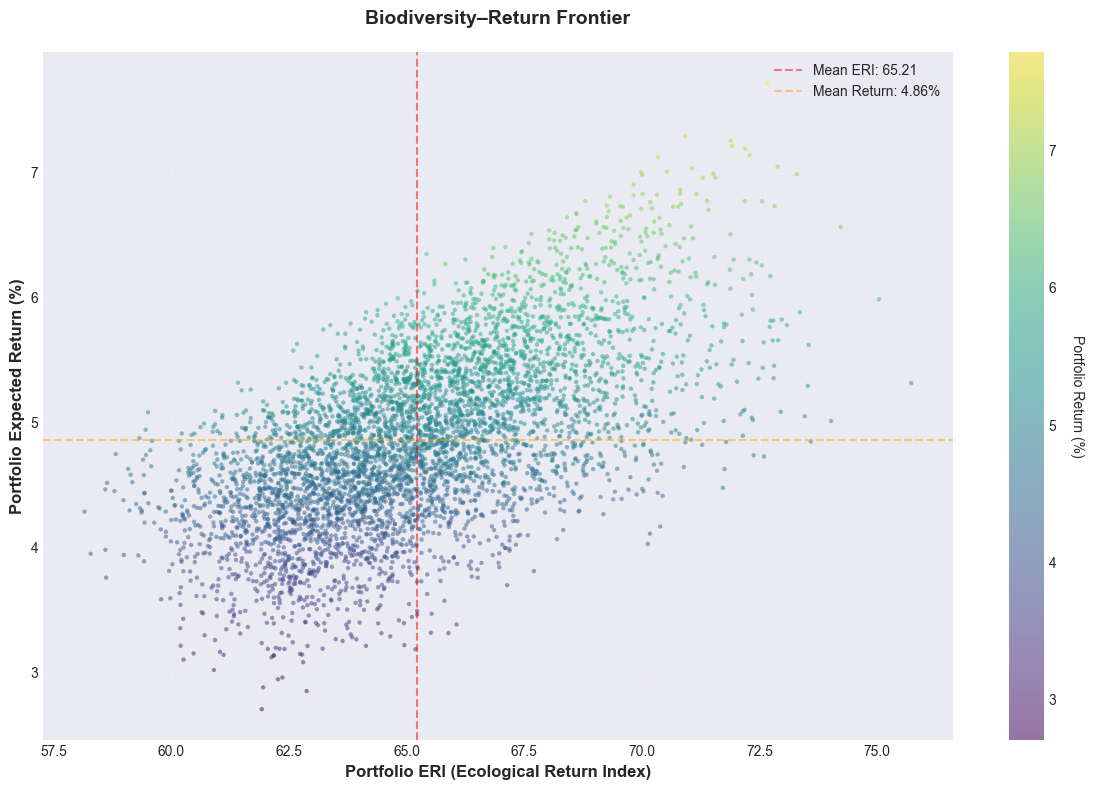

In [42]:
# Create the biodiversity-return frontier plot
plt.figure(figsize=(12, 8))

# Create scatter plot with color gradient based on density
scatter = plt.scatter(portfolio_eris, portfolio_returns,
                     alpha=0.5,
                     s=10,
                     c=portfolio_returns,
                     cmap='viridis',
                     edgecolors='none')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Portfolio Return (%)', rotation=270, labelpad=20)

# Add labels and title
plt.xlabel('Portfolio ERI (Ecological Return Index)', fontsize=12, fontweight='bold')
plt.ylabel('Portfolio Expected Return (%)', fontsize=12, fontweight='bold')
plt.title('Biodiversity–Return Frontier', fontsize=14, fontweight='bold', pad=20)

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Add reference lines for mean values
mean_eri = portfolio_eris.mean()
mean_return = portfolio_returns.mean()
plt.axvline(mean_eri, color='red', linestyle='--', alpha=0.5, label=f'Mean ERI: {mean_eri:.2f}')
plt.axhline(mean_return, color='orange', linestyle='--', alpha=0.5, label=f'Mean Return: {mean_return:.2f}%')

plt.legend(loc='best')
plt.tight_layout()

# Save the plot to figures folder
plt.savefig('figures/biodiversity_return_frontier.png', dpi=300, bbox_inches='tight')
print("Plot saved as: figures/biodiversity_return_frontier.png")

plt.show()

Efficient frontier plot saved as: figures/biodiversity_return_efficient_frontier.png


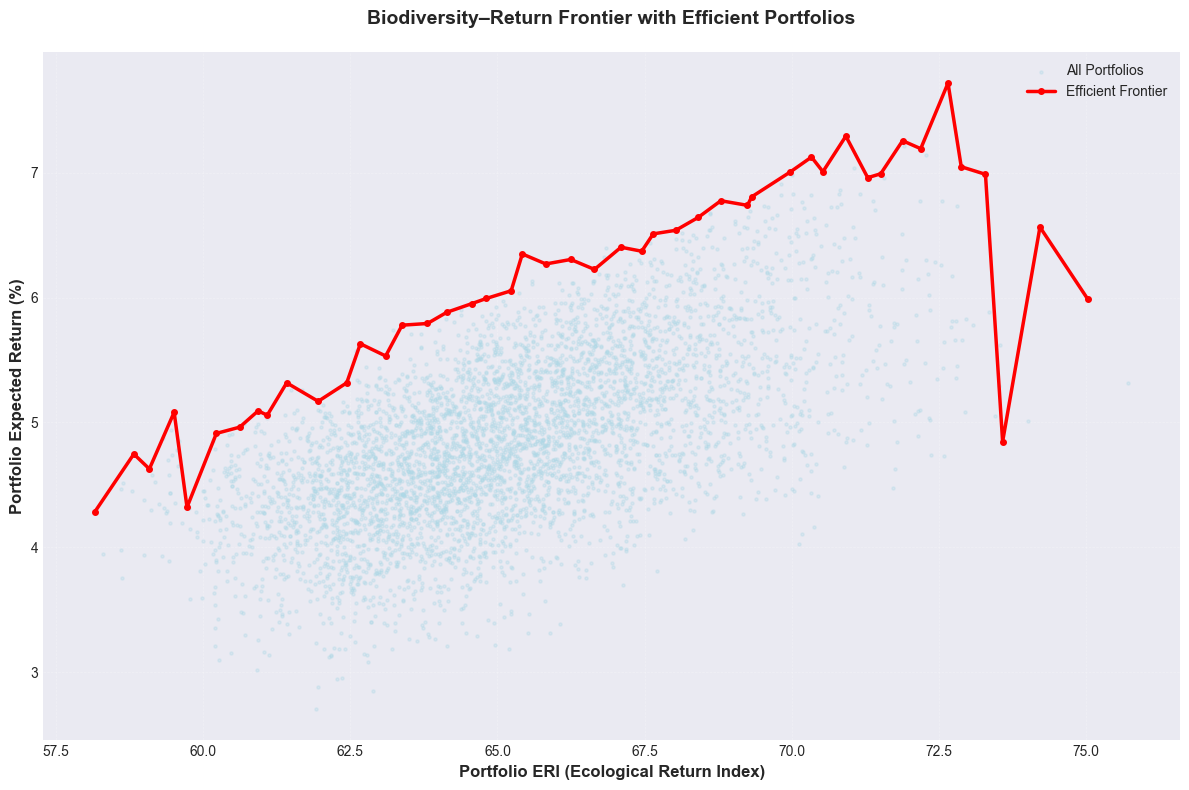

In [43]:
# Additional visualization: Efficient frontier (upper envelope)
plt.figure(figsize=(12, 8))

# Plot all portfolios
plt.scatter(portfolio_eris, portfolio_returns,
           alpha=0.3,
           s=5,
           color='lightblue',
           label='All Portfolios')

# Find efficient frontier points (maximum return for each ERI level)
# Bin ERIs and find max return in each bin
n_bins = 50
eri_bins = np.linspace(portfolio_eris.min(), portfolio_eris.max(), n_bins)
bin_indices = np.digitize(portfolio_eris, eri_bins)

efficient_eris = []
efficient_returns = []

for i in range(1, n_bins):
    mask = bin_indices == i
    if mask.any():
        max_return_idx = portfolio_returns[mask].argmax()
        efficient_eris.append(portfolio_eris[mask][max_return_idx])
        efficient_returns.append(portfolio_returns[mask][max_return_idx])

# Sort for plotting
sorted_indices = np.argsort(efficient_eris)
efficient_eris = np.array(efficient_eris)[sorted_indices]
efficient_returns = np.array(efficient_returns)[sorted_indices]

# Plot efficient frontier
plt.plot(efficient_eris, efficient_returns,
        color='red',
        linewidth=2.5,
        label='Efficient Frontier',
        marker='o',
        markersize=4)

plt.xlabel('Portfolio ERI (Ecological Return Index)', fontsize=12, fontweight='bold')
plt.ylabel('Portfolio Expected Return (%)', fontsize=12, fontweight='bold')
plt.title('Biodiversity–Return Frontier with Efficient Portfolios', fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
plt.legend(loc='best')
plt.tight_layout()

# Save this plot to figures folder
plt.savefig('figures/biodiversity_return_efficient_frontier.png', dpi=300, bbox_inches='tight')
print("Efficient frontier plot saved as: figures/biodiversity_return_efficient_frontier.png")

plt.show()

## Summary and Next Steps

### Key Findings:
1. **Data Coverage**: Analyzed industry-level ESG and financial performance
2. **ERI Calculation**: Successfully integrated environmental scores with biodiversity indicators
3. **Portfolio Analysis**: Simulated 5000 portfolios to map the biodiversity-return frontier
4. **Visualizations**: Created comprehensive plots showing trade-offs and efficient allocations

### To Use Real Biodiversity Data:
Simply replace the `bio_df` DataFrame in Section 3 with actual data containing:
- `Region`: Geographic region identifier
- `BI`: Biodiversity Index (0-100 scale)
- `BIC_per_year`: Annual biodiversity investment costs

The rest of the analysis will automatically incorporate the real data.

In [44]:
# Export results for further analysis
merged_data.to_csv('data/industry_eri_summary.csv', index=False)
portfolio_df.to_csv('data/portfolio_simulations.csv', index=False)

print("Results exported:")
print("  - data/industry_eri_summary.csv")
print("  - data/portfolio_simulations.csv")
print("\nAnalysis complete!")

Results exported:
  - data/industry_eri_summary.csv
  - data/portfolio_simulations.csv

Analysis complete!
